# Segmentation pipeline 
### 1. Calibration: 
- Loaded the control bright field image(2048,2048), control raman dat file(100x100) and control raman png file.
- Extracted raman peak 669 from the raman dat file and rotated by 180. 
- Matched the raman peak 669 image(template) with the control bright field image(image) to find the raman field of view on the brightfield image. 
- Upsample raman image according to the dimensions retrieved from template matching.
- Checked calibration by overlaying raman image pasted on a white image(2048x2048) on the control brightfield image(2048x2048)

### 2. Process segmented masks
- Loaded the segmented mask images(2048x2048). 
- Cropped the raman view field from the segmented images
- Downsampled the cropped segmented masks(100x100)

### 3. Map Raman Data 
- Loaded the raman data from the dat files
- Assigned raman spectra to every pixel in each cell of the downsampled cropped segmented masks. 
- Generated a spatial dataset from above with column names as image, cell#, spectra#, pixel position and the corresponding raman spectra. 
- Generated a non spatial dataset by computing mean spectra for every cell. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
from scipy import ndimage
from PIL import Image, ImageChops
import skimage.measure as measure 
import imutils
from tqdm import tqdm
from skimage import color
import seaborn as sns 
from natsort import natsorted
from segmentation_helpers import *
import re
import collections
import pandas as pd
import tifffile as tf

In [2]:
'''Path to directories - nuclei stain images and raman images'''
nuclei_stain_path = './raman_10_20_20/raman_nuclei_stain'
hcr_nuclei_stain_path = './raman_10_20_20/hcr_nuclei_stain'
raman_path = './raman_10_20_20/raman'
gfp_path = './raman_10_20_20/gfp'
hcr_path = './raman_10_20_20/hcr'

## Calibration 

In [3]:
'''path to control files'''
bright_field_file = './raman_10_20_20/brightfield/control.ome.tif'
control_raman_file = './raman_10_20_20/raman/control.dat'

In [4]:
'''read bright field image, raman dat file, raman png file'''
control_brightfield = tf.imread(bright_field_file)
raman_dat =pd.read_csv(control_raman_file, delimiter='\t', header=None)
raman_dat = raman_dat.to_numpy()

In [5]:
print(control_brightfield.shape), print(raman_dat.shape);

(2048, 2048)
(10000, 1340)


In [6]:
'''extract 669 peak of the raman spectra'''
raman_dat_669 = np.reshape(raman_dat[:,668],(100,100))

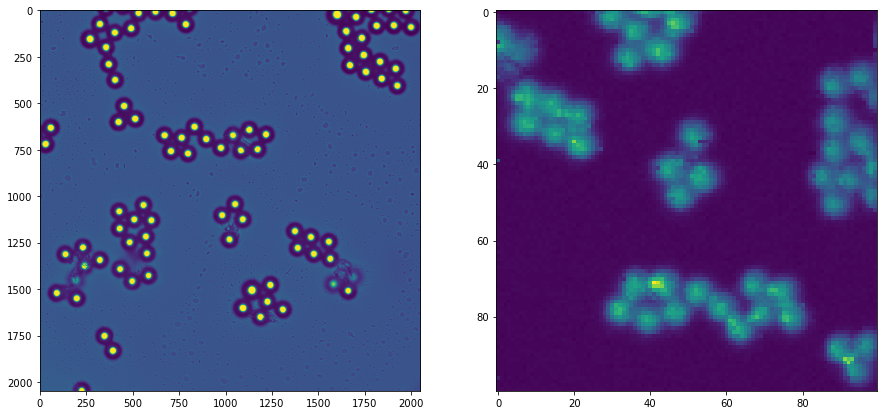

In [7]:
fig,ax = plt.subplots(1,2,figsize = (15,15))
ax[0].imshow(control_brightfield)
ax[1].imshow(raman_dat_669);
#ax[2].imshow(raman_png);

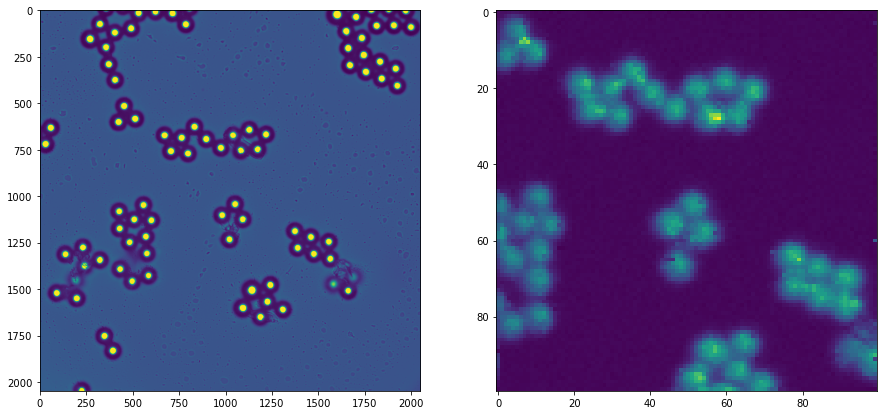

In [8]:
'''rotate raman dat to match raman png'''
rot_raman = np.rot90(raman_dat_669,2,(0,1))
fig,ax = plt.subplots(1,2,figsize = (15,15))
ax[0].imshow(control_brightfield)
ax[1].imshow(rot_raman);

In [9]:
'''Multiscale template matching - img=control_brightfield and template=raman dat file(typecast to uint8)'''

loc_dims = match_temp(np.uint8(control_brightfield),np.uint8(rot_raman))


100%|██████████| 1948/1948 [02:59<00:00, 10.87it/s]


In [10]:
(_,location,dimensions) = loc_dims

print(location),print(dimensions);

(49, 62)
1647


In [11]:
'''adjust dimensions and location here to get almost perfect match'''
location=(410, 405)
dimensions = 1242

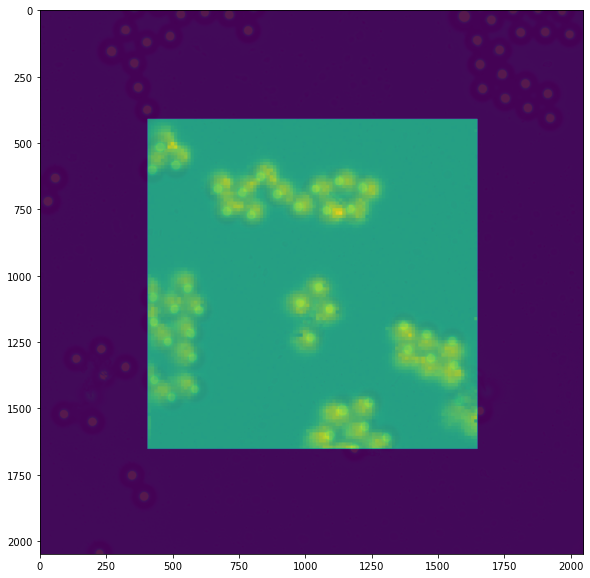

In [12]:
'''upsample raman to matched dimensions'''
raman_1354 = upsample(rot_raman,dimensions)
raman_im = np.zeros(control_brightfield.shape[0:2])
x = location[0]
y = location[1]
raman_im[x:x+dimensions, y:y+dimensions] = raman_1354
fig,axs = plt.subplots(1,1,figsize=(10,10))
plt.imshow(control_brightfield)
plt.imshow(raman_im, alpha=.9);

## Process segmented masks

### Read segmentation masks, nuclei stain images and control image. 

In [13]:
'''Get segmented files'''
labelled_images = './raman_10_20_20/raman_labelled/'
hcr_labelled_images = './raman_10_20_20/hcr_labelled/'
labelled_files = []
mask_names = []
for _,_,files in os.walk(labelled_images):
    for file in files:
        if(file!='.DS_Store' and file!='control.ome.tif'):
            mask_names.append("_".join([file.split("_", 2)[0],file.split("_", 2)[1].split(".")[0]]))
            labelled_files.append(labelled_images+file)

In [14]:
'''sanity check'''
np.shape(mask_names),np.shape(labelled_files)

((283,), (283,))

In [15]:
'''Read mask images'''
masks = []
for labelled_file in tqdm(labelled_files):
    if(labelled_file!='./raman_10_20_20/raman_labelled/.DS_Store'):
        mask = tf.imread(labelled_file)
        masks.append(mask)
        

100%|██████████| 283/283 [00:07<00:00, 36.24it/s]


In [16]:
'Read control mask'
control = tf.imread('./raman_10_20_20/raman_labelled/control.ome.tif')

In [17]:
'Read gfp files'
gfps = []
gfp_missing = []
for name in tqdm(mask_names):
    if(os.path.isfile(os.path.join(gfp_path,name+'.tif'))):
        gfp_file = plt.imread(os.path.join(gfp_path,name+'.tif'))
    else:
        gfp_file=[]
        gfp_missing.append(name)
    gfps.append(gfp_file)

100%|██████████| 283/283 [00:14<00:00, 19.09it/s]


### hcr file read

In [18]:
genes = ['Nanog','Bgn','Col1a1','Krt7','Peg10','Utf1','Epcam','Nnat','Fabp1']
hcr_list_dict = collections.defaultdict(list)

In [19]:
'Read hcr files'
left_out=[]
for gene in genes: 
    for name in tqdm(mask_names):
        if(os.path.isfile(os.path.join(hcr_path,gene,name+'.tif'))):
            hcr_file = plt.imread(os.path.join(hcr_path,gene,name+'.tif'))
        else:
            hcr_file=[]
            left_out.append(name)
        hcr_list_dict[gene].append(hcr_file)

100%|██████████| 283/283 [00:06<00:00, 40.89it/s]


***

In [20]:
'to include control images for nuclei stain but not for segmentation masks. Will include control for segmentation masks after filtering'

mask_names.append('control')

In [21]:
'Read nuclei stain images including control nuclei stain image'
ns_images = []
for name in tqdm(mask_names):
    if(os.path.isfile(os.path.join(nuclei_stain_path,name+'.tif'))):
        ns_image = plt.imread(os.path.join(nuclei_stain_path,name+'.tif'))
    ns_images.append(ns_image)

100%|██████████| 284/284 [00:16<00:00, 17.66it/s]


In [22]:
'''sanity check'''
np.shape(masks),np.shape(ns_images),np.shape(control),np.shape(masks[0])

((283,), (284, 2048, 2048), (2048, 2048), (2046, 2046))

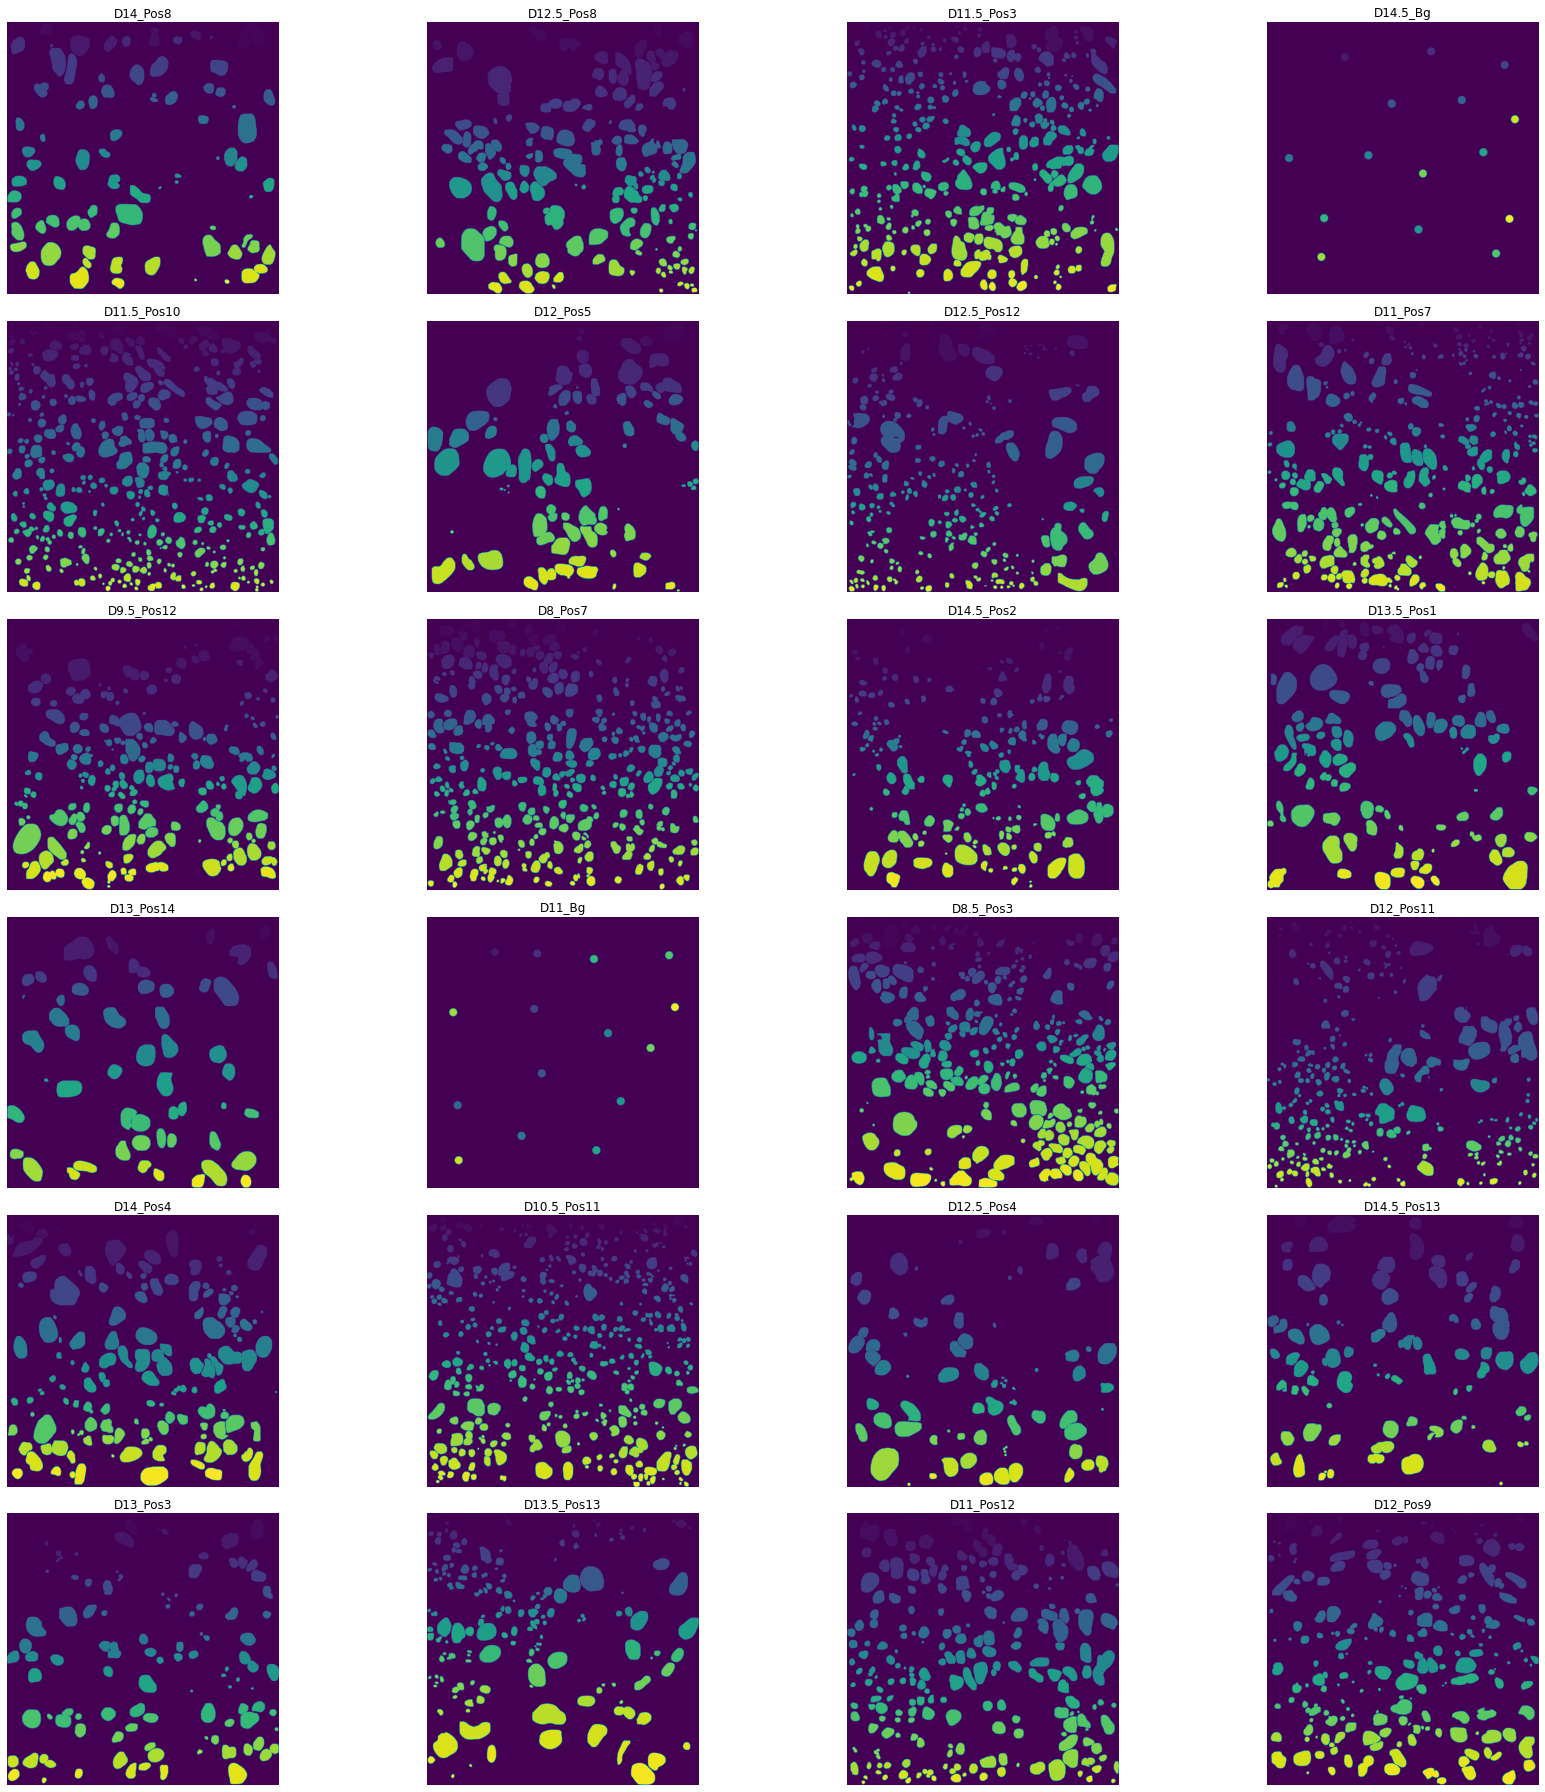

In [23]:
'''Plot mask images'''
plot_all(mask_names,masks,rows=6,columns=4)

### Resize labels to 2048

In [24]:
'''after segmentation, the segmentation masks are of size 2046x2046, so upsample the dimensions to 2048'''
masks_2048 = []
for m in masks:
    masks_2048.append(upsample(np.uint8(m),2048))

### Crop raman field of view from nuclei stain, segmentation masks and control mask

In [25]:
'''Crop raman view field from the segmentation masks'''
cropped_masks = crop2d(masks_2048,location,dimensions)

'Crop raman view field from the nuclei stain images'
cropped_ns = crop2d(ns_images,location,dimensions)
    
'Crop raman view field from the control mask image'
cropped_control = crop1d(control,location,dimensions)

'Crop raman view field from gfp images'
cropped_gfp = crop2d(gfps,location,dimensions)


In [26]:
'Crop raman view field from hcr images'
cropped_hcr = collections.defaultdict(list)
for gene in genes:
    for hcr_gene in hcr_list_dict[gene]:
        if np.shape(hcr_gene)[0]==0:
            cropped_hcr[gene].append([])
        else:
            cropped_hcr[gene].append(crop1d(hcr_gene,location,dimensions))
            

In [27]:
np.shape(cropped_masks),np.shape(cropped_ns),np.shape(cropped_control), np.shape(cropped_gfp)

((283, 1242, 1242), (284, 1242, 1242), (1242, 1242), (283, 1242, 1242))

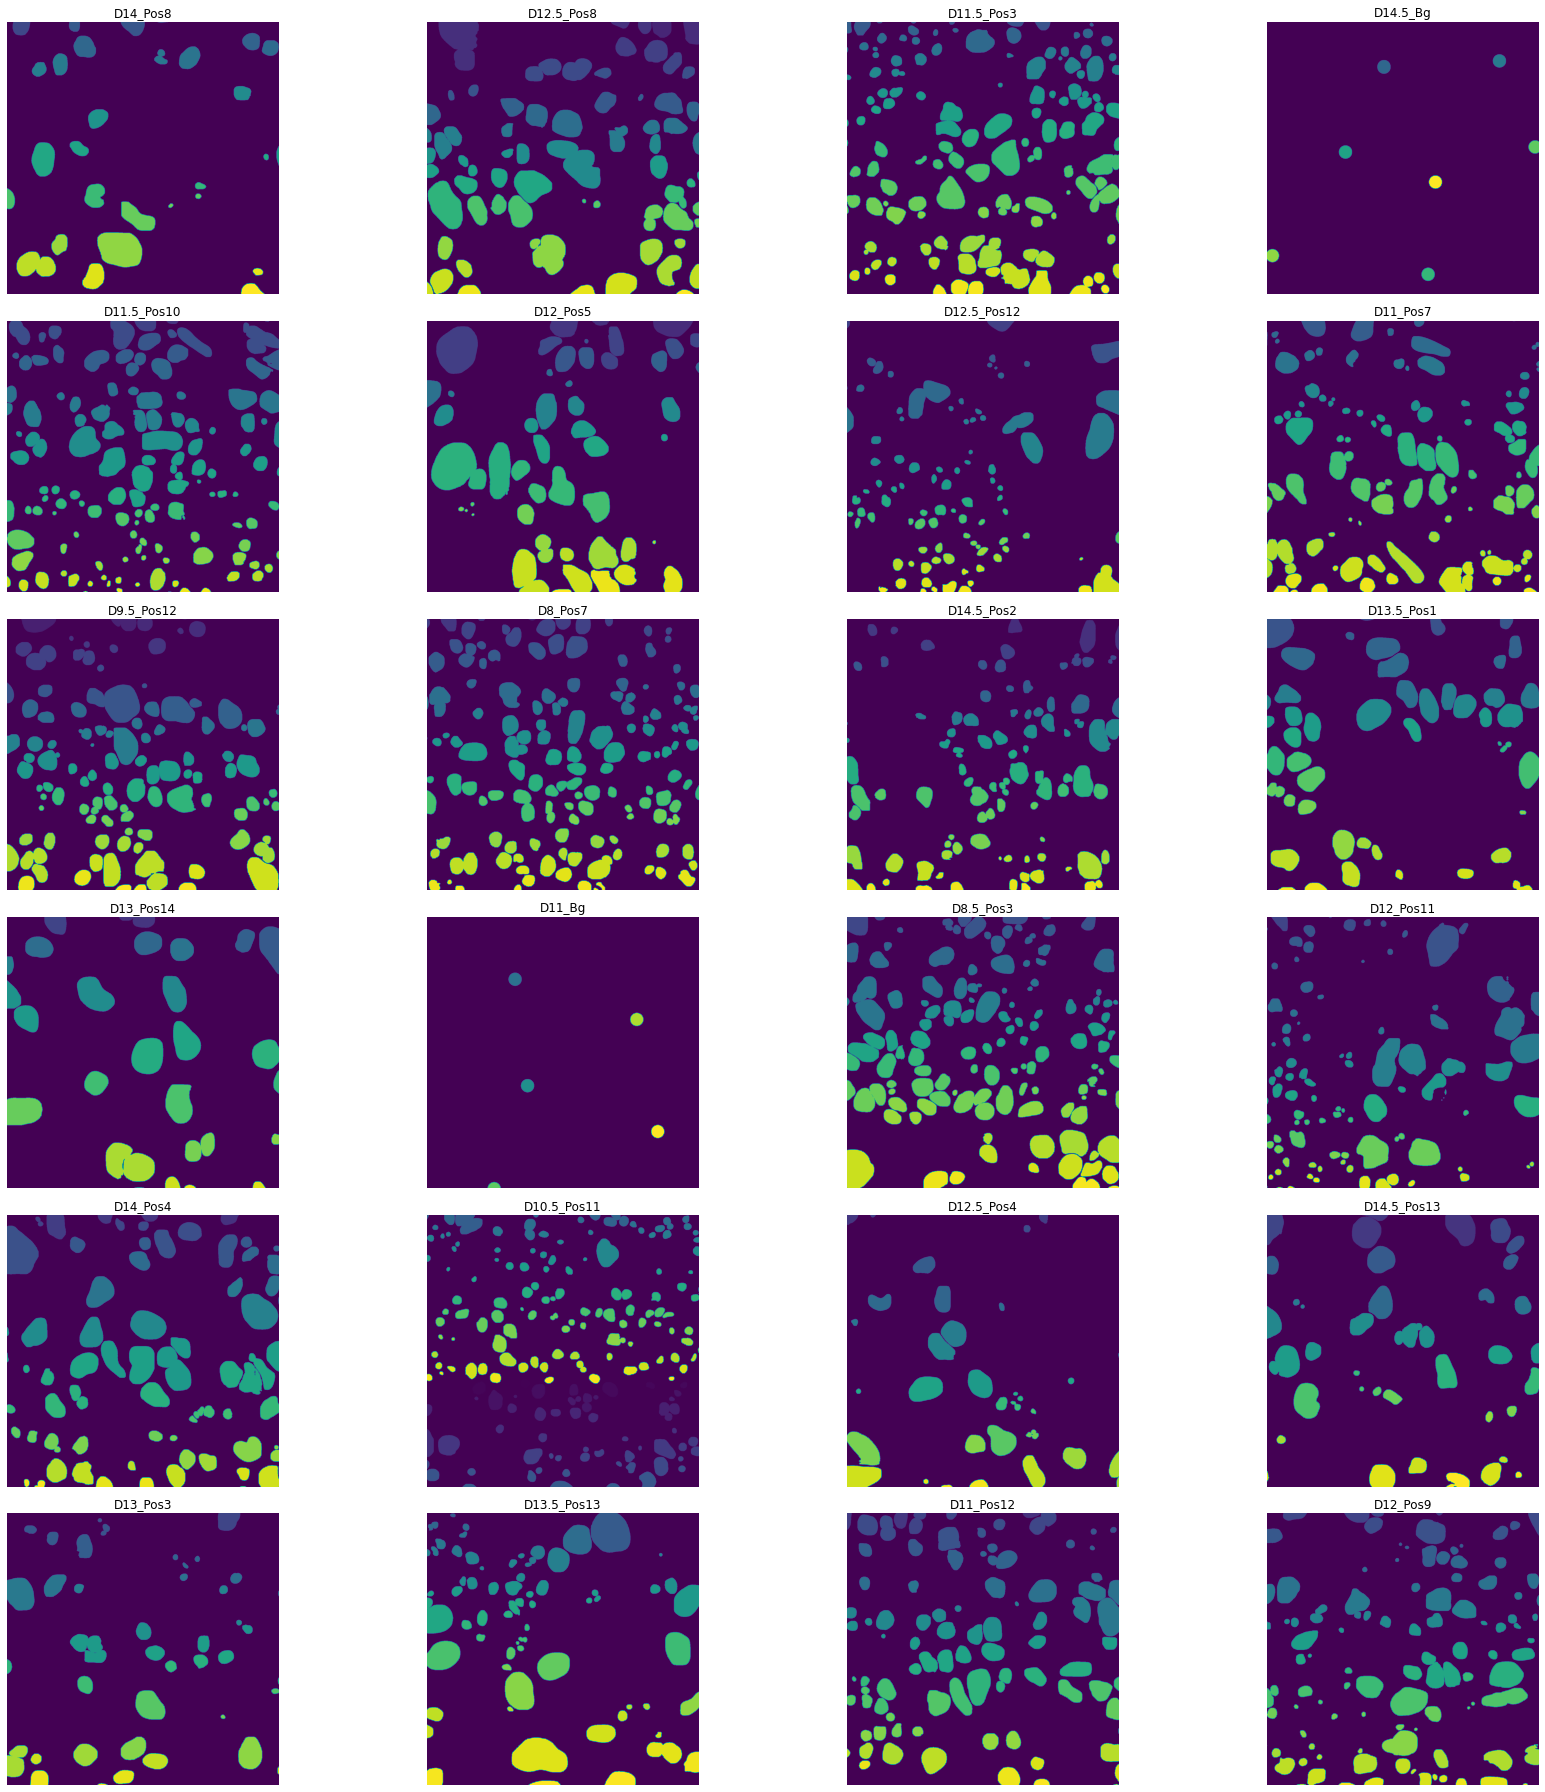

In [28]:
'''Plot cropped masks'''
plot_all(mask_names,cropped_masks,rows=6,columns=4)

### Downsample segmentation masks,nuclei stain and control mask

In [29]:
'Downsample segmentation masks to 100x100'
small_masks = []
for cm in cropped_masks:
    small_masks.append(downsample(cm,100))

'Downsample nuclei stain images to 100x100'
small_ns=[]
for cn in cropped_ns:
    small_ns.append(downsample(cn,100))

'Downsample control mask to 100x100'
small_control = downsample(cropped_control,100)

'Downsample gfp images to 100x100'
small_gfp=[]
for cg in cropped_gfp:
    small_gfp.append(downsample(cg,100))
    

In [30]:
'Downsample hcr images to 100x100'
small_hcr = collections.defaultdict(list)
for gene in genes:
    for ch in cropped_hcr[gene]:
        if np.shape(ch)[0]==0:
            small_hcr[gene].append([])
        else:
            small_hcr[gene].append(downsample(ch,100))

In [31]:
np.shape(small_masks),np.shape(small_ns),np.shape(small_control),np.shape(small_gfp)

((283, 100, 100), (284, 100, 100), (100, 100), (283, 100, 100))

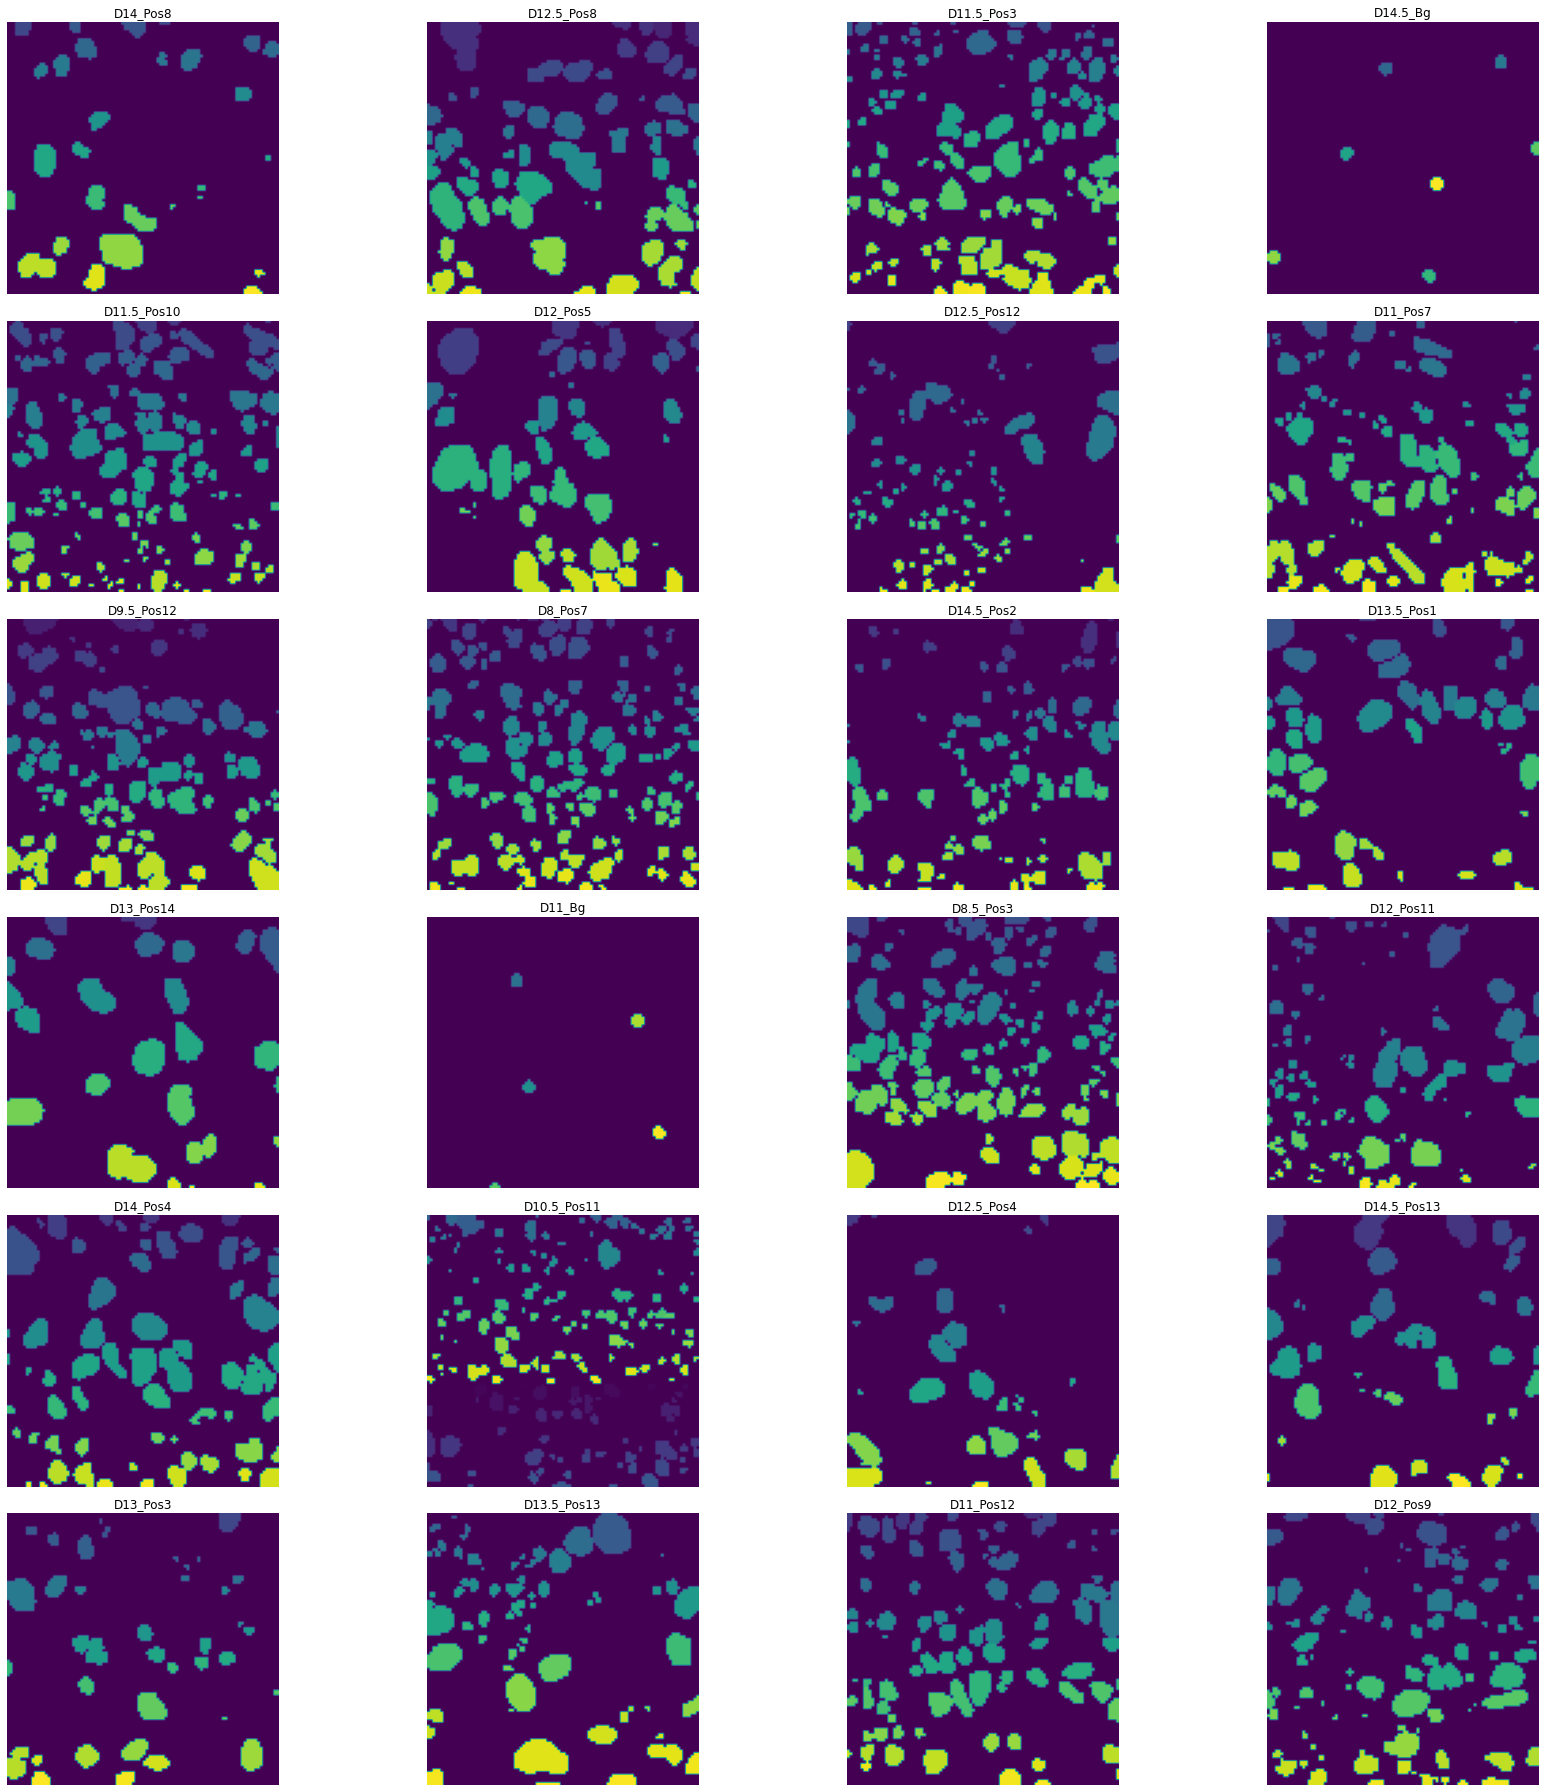

In [32]:
'''Plot down-sampled cropped mask '''
plot_all(mask_names,small_masks,rows=6,columns=4)

### Cell area distribution before filtering(removing small cells and cells along the border)

In [33]:
'Find areas for each of the cells'
areas = []
for sm in small_masks:
    props = measure.regionprops(sm)
    for prop in props:
        areas.append(prop.area)

In [34]:
np.shape(areas)

(20394,)

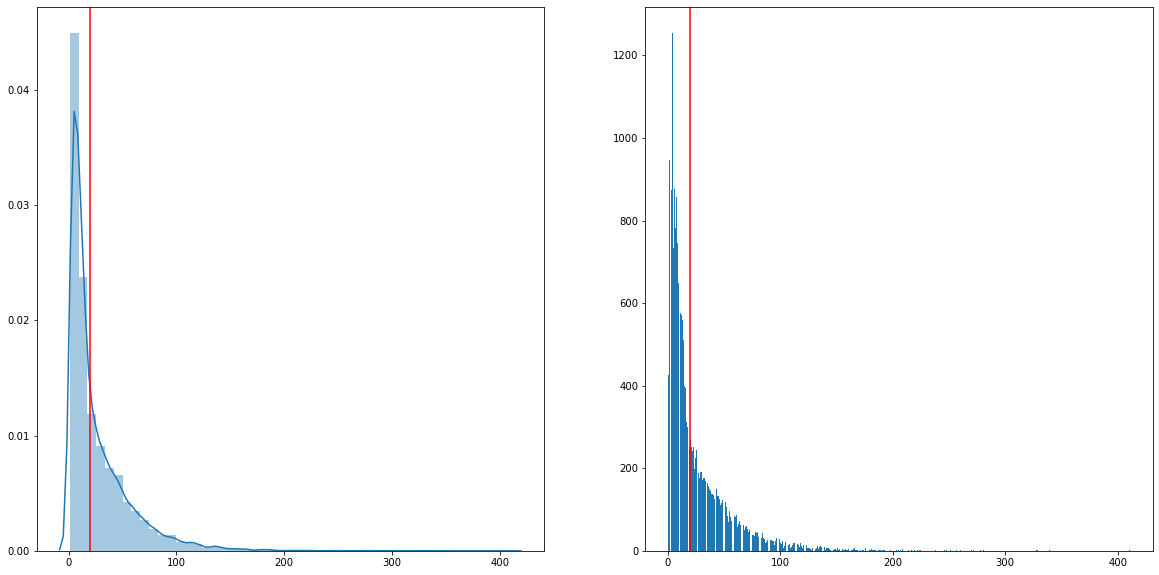

In [35]:
'''plot areas of cells'''
unique_ele, counts = np.unique(areas, return_counts = True)
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.distplot(areas,ax=ax[0])
ax[0].axvline(x=20,color='RED')
ax[1].bar(unique_ele,counts)
ax[1].axvline(x=20,color='RED');

### Remove cells from border 

In [36]:
filtered_masks = remove_border(small_masks)

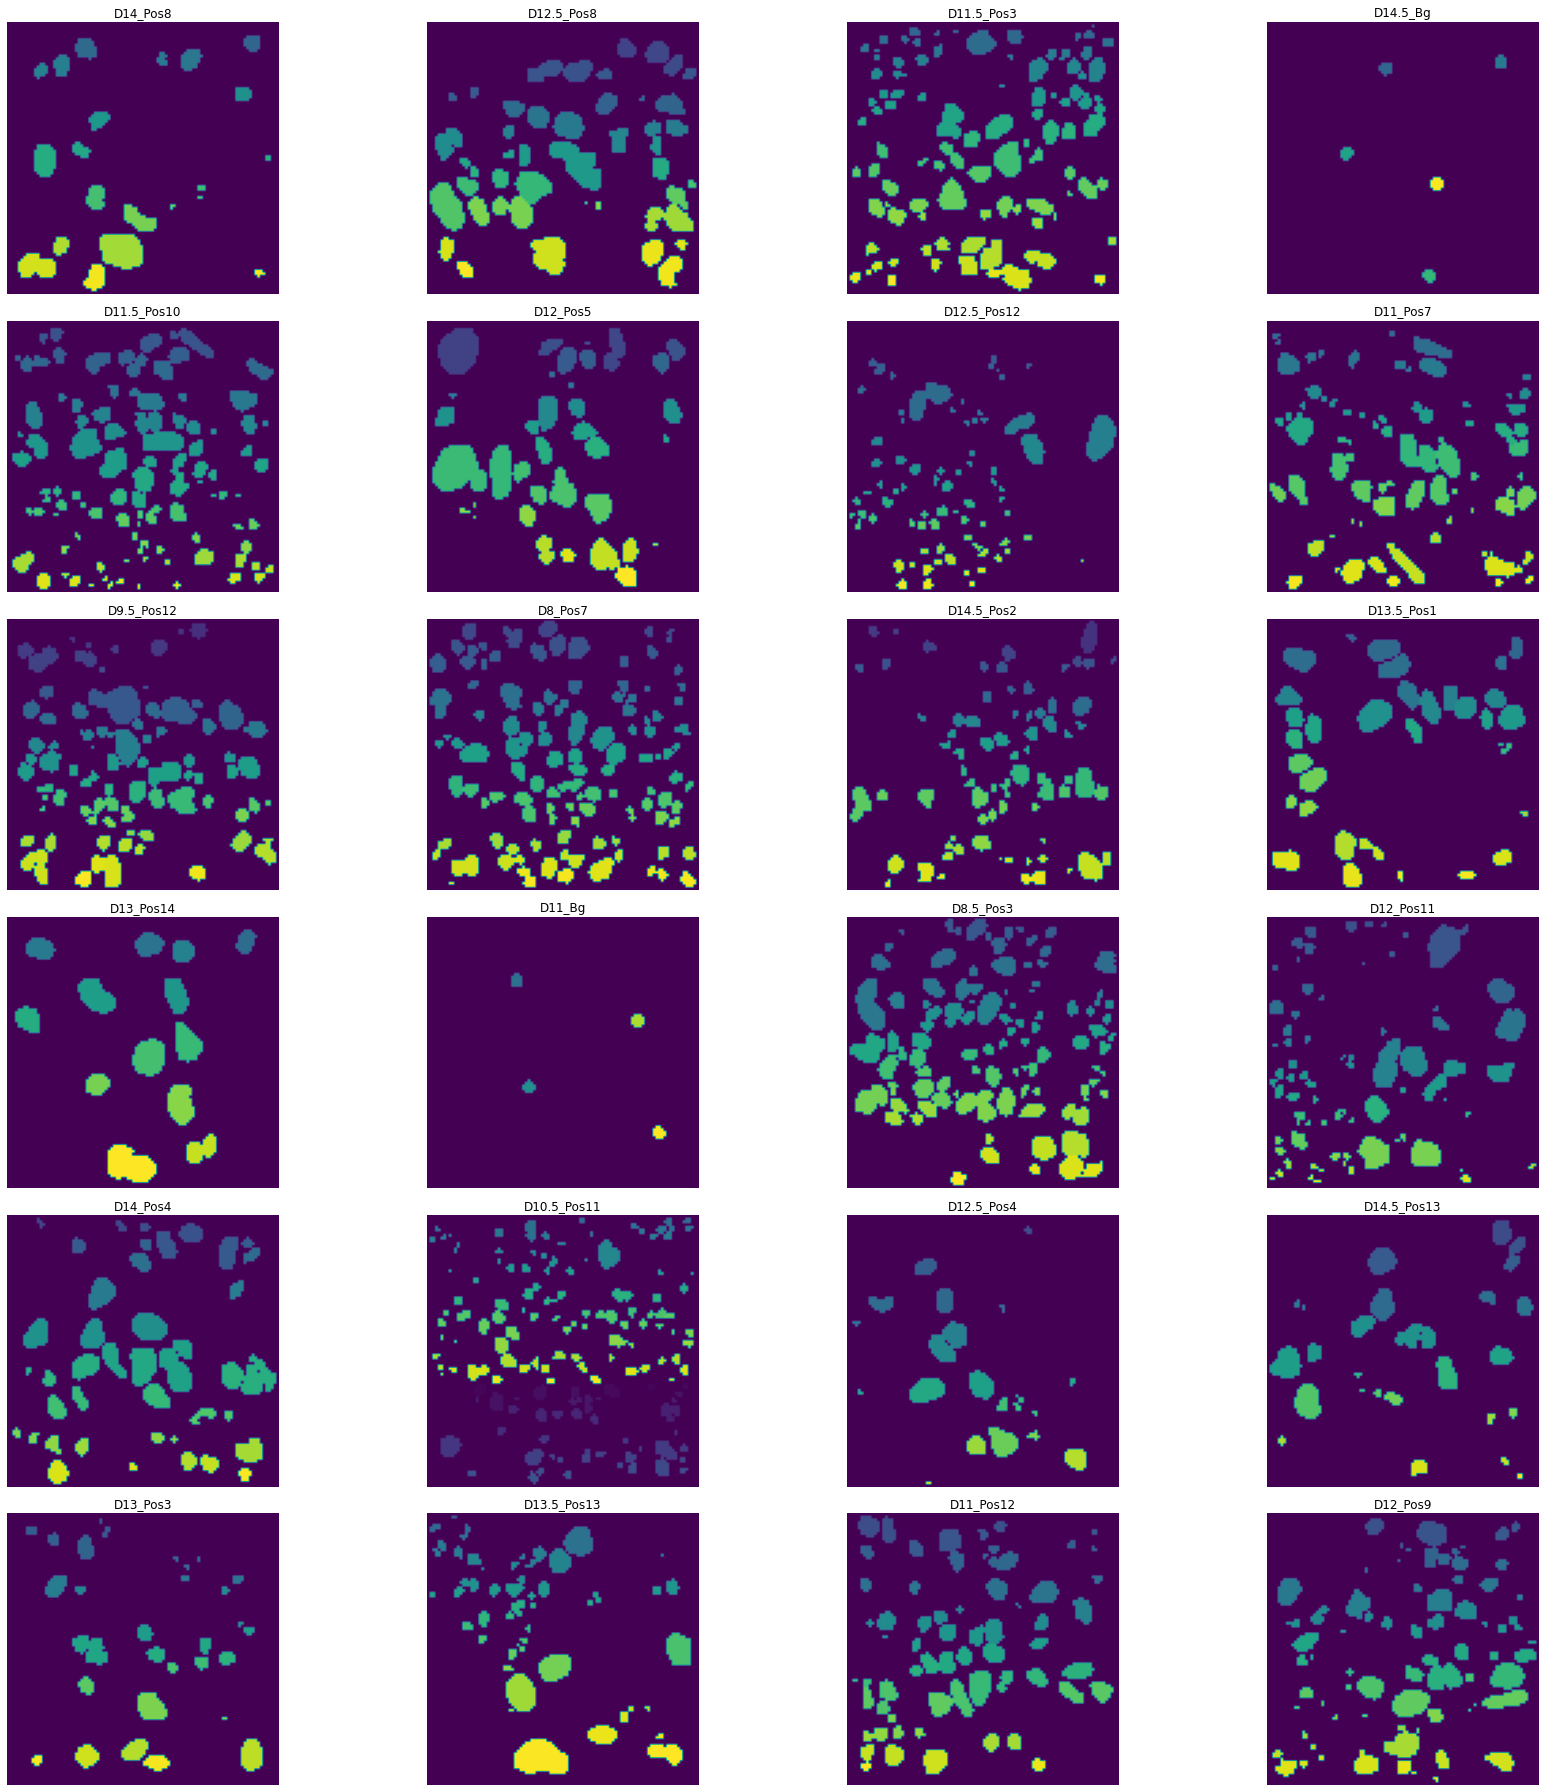

In [37]:
plot_all(mask_names,filtered_masks,rows=6,columns=4)

### Remove small objects 

In [38]:
'FILTER-Remove small cells of area less than 20'
super_filtered_masks = remove_small(filtered_masks,area=20)

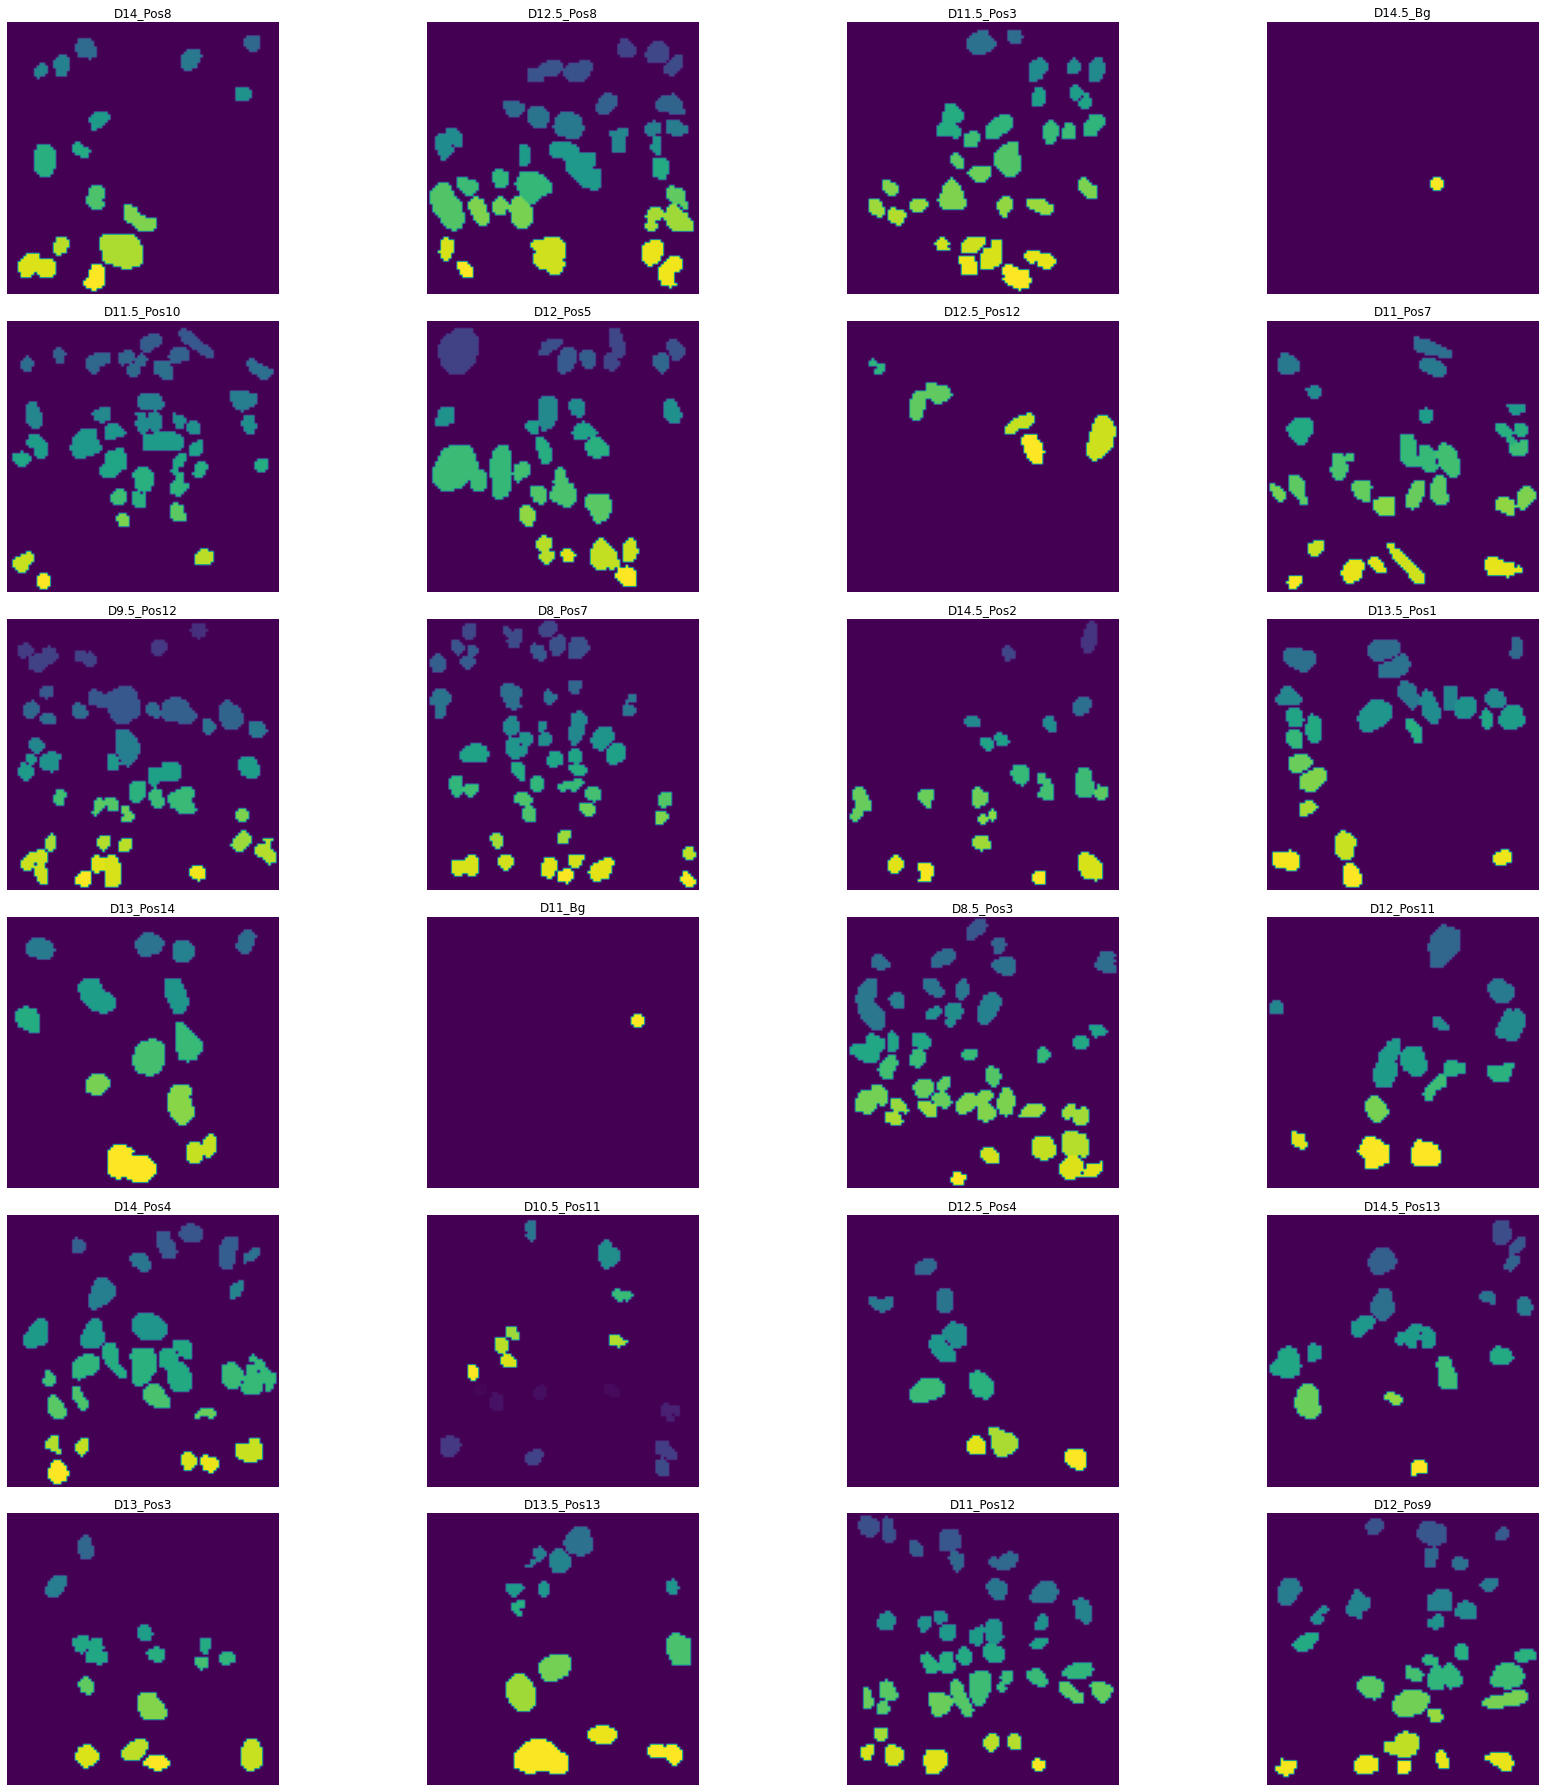

In [39]:
plot_all(mask_names,super_filtered_masks,rows=6,columns=4)

### Cell area distribution after filtering 

In [40]:
areas_filtered = []
for sfm in super_filtered_masks:
    props = measure.regionprops(sfm)
    for prop in props:
        areas_filtered.append(prop.area)

In [41]:
np.shape(areas_filtered)

(6559,)

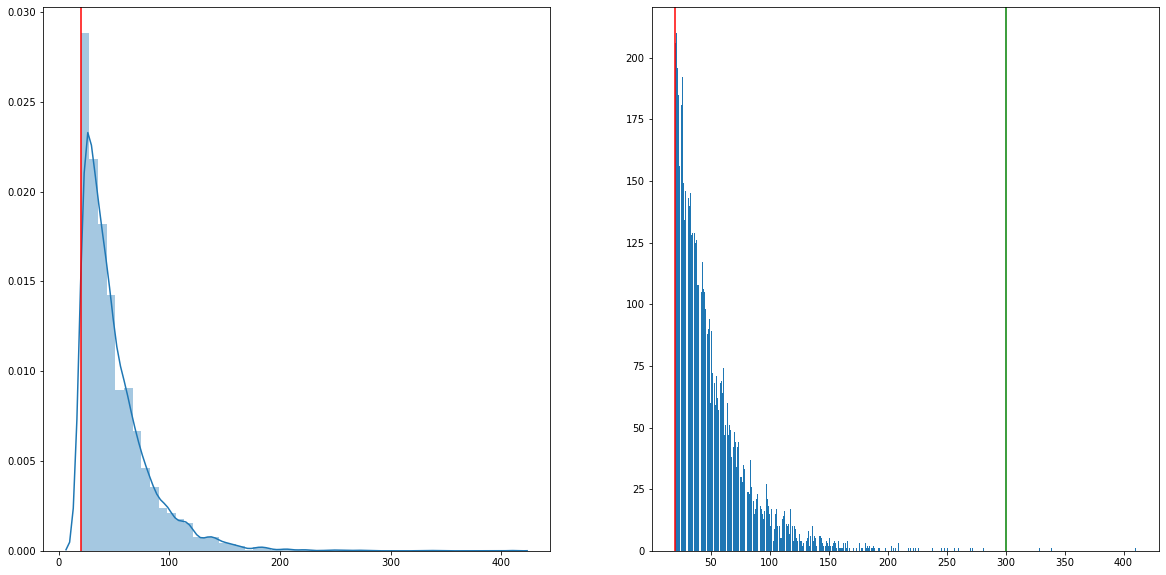

In [42]:
'''plot areas of cells'''
elements, counts = np.unique(areas_filtered, return_counts = True)
fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.distplot(areas_filtered,ax=ax[0])
ax[0].axvline(x=20,color='RED')
ax[1].bar(elements,counts)
ax[1].axvline(x=20,color='RED')
ax[1].axvline(x=300,color='GREEN');

### Check if cell area>300 are actual cells 

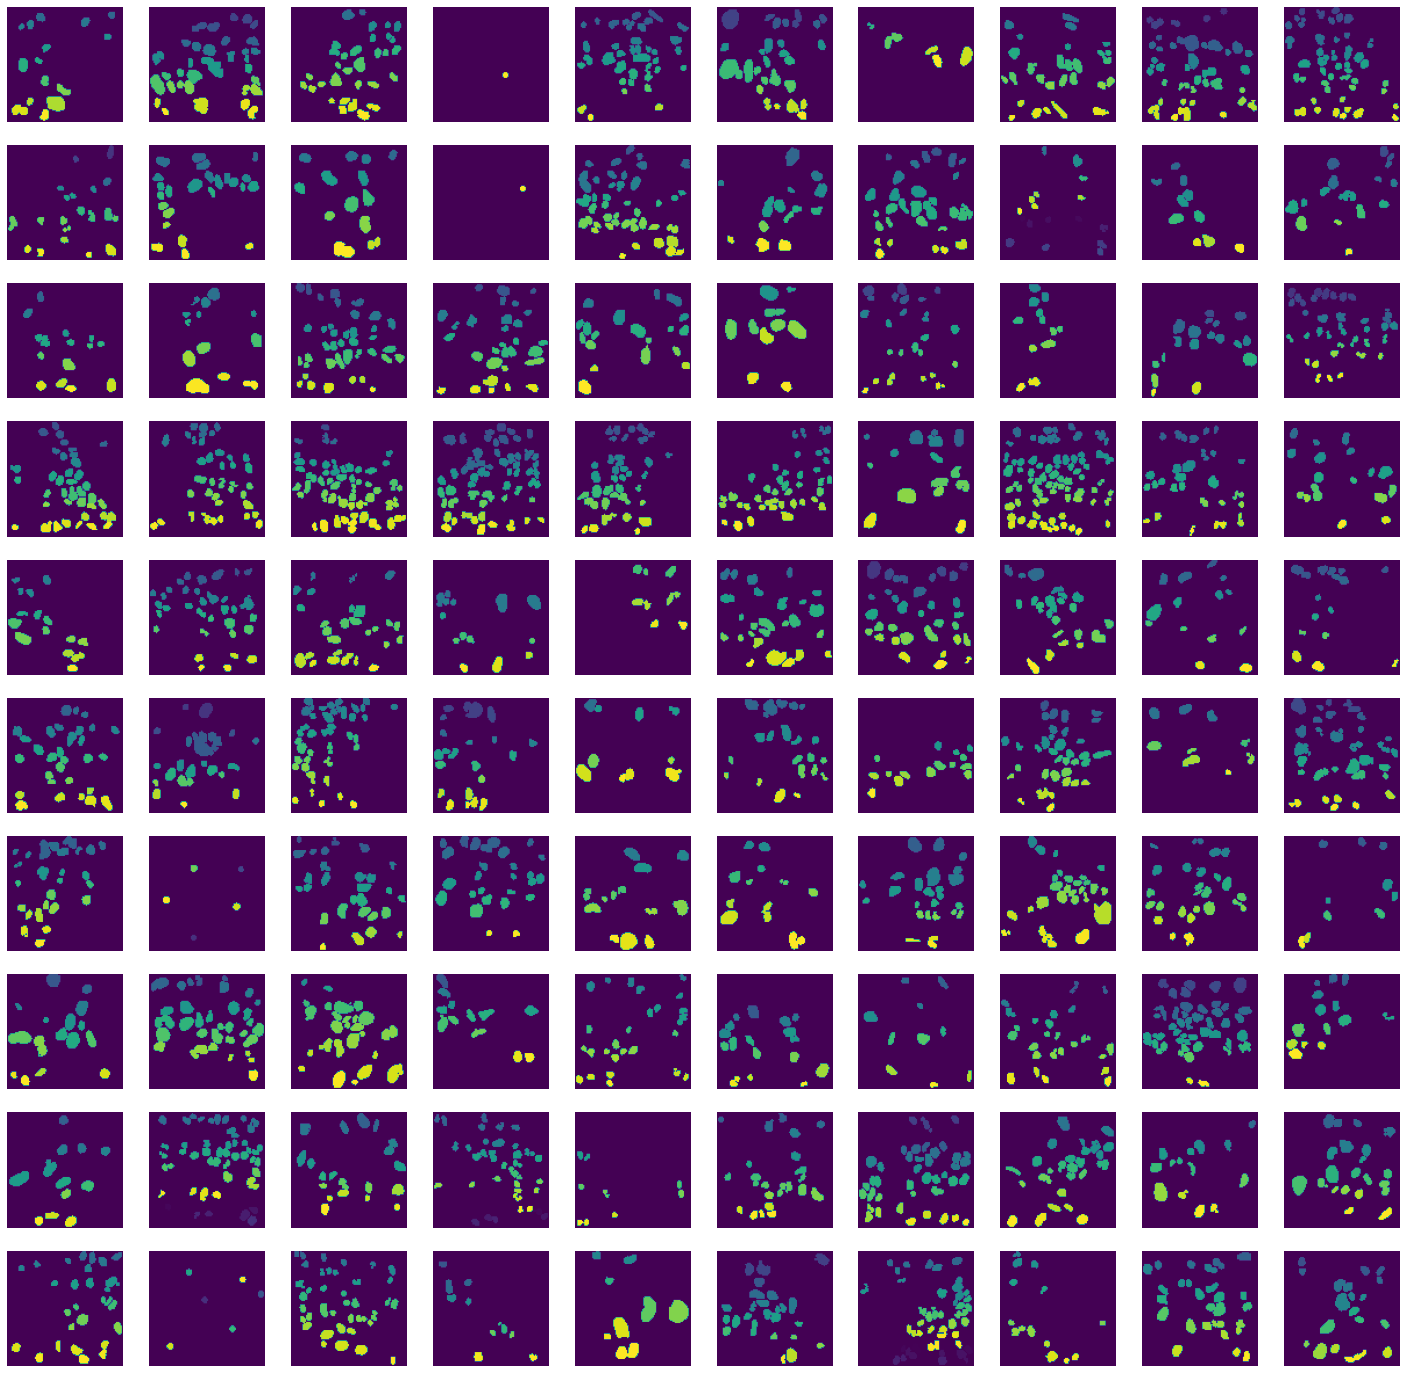

In [43]:
validate_big_cells(super_filtered_masks,area=300,rows=10,columns=10)

In [44]:
'add control image to masks'
super_filtered_masks.append(small_control)

In [45]:
np.shape(super_filtered_masks),np.shape(mask_names)

((284, 100, 100), (284,))

## Control images for segmentation 

In [ ]:
''' Left panel: Nuclei Stain 
    Middle panel: Segmentation masks 
    Right panel: Overlay of Nuclei stain and segmentation masks 
    save control plots as pdf '''

from matplotlib.backends.backend_pdf import PdfPages
with PdfPages('./raman_10_20_20/rns_seg_control_1029.pdf') as pdf:
    fig,axs = plt.subplots(1,3,figsize=(15,15))
    for name,nuclei,mask in zip(mask_names,small_ns,super_filtered_masks):
        axs[0].imshow(nuclei*5)
        axs[1].imshow(mask,cmap='coolwarm')
        axs[2].imshow(nuclei*5)
        axs[2].imshow(mask,cmap='coolwarm',alpha=0.5)
        axs[0].set_title(name+' - Nuclei Stain')
        axs[1].set_title(name+' - Segmentation Mask')
        axs[2].set_title(name+' - Overlay')
        pdf.savefig();

## Map Raman Data

In [46]:
'''Extract Raman Spectra from dat files'''
raman_specs = []
raman_missing = []
for file in tqdm(mask_names):
    if(os.path.isfile(os.path.join(raman_path,file+'.dat'))):
        ramans_raw =pd.read_csv(os.path.join(raman_path,file+'.dat'), delimiter='\t', header=None)
        ramans = np.reshape(ramans_raw.to_numpy(),(100,100,1340))
        raman_specs.append(np.rot90(ramans,2,(0,1)))
    else:
        raman_missing.append(file)   

100%|██████████| 284/284 [04:41<00:00,  1.01it/s]


In [47]:
raman_missing

[]

In [48]:
np.shape(super_filtered_masks), np.shape(raman_specs)

((284, 100, 100), (284, 100, 100, 1340))

In [49]:
'''Mapping each pixel in each cell to raman spectra'''
label_pos = cell_positions(super_filtered_masks)

In [50]:
'''Create a dict - image,cell-id,spectra-id,pixelpos'''
cell_ram = {'image','cell_id','spectra','pix_x','pix_y','pixel_id'}
cell_ram = dict([(key, []) for key in cell_ram])
for pos,ram,name in zip(label_pos,raman_specs,mask_names):
    for coords,cc in zip(pos,range(len(pos))):
        for coord,sc in zip(coords,range(len(coords))):
            cell_ram['image'].append(name)
            cell_ram['cell_id'].append(name+'_'+'cell'+str(cc+1))
            cell_ram['spectra'].append(ram[coord[0],coord[1]])
            cell_ram['pix_x'].append(coord[0])
            cell_ram['pix_y'].append(coord[1])
            cell_ram['pixel_id'].append(name+'_'+'cell'+str(cc+1)+'_'+'pix'+str(sc+1))

In [51]:
'''Create spatial dataframe'''
import pandas as pd
spatial = pd.DataFrame.from_dict(cell_ram)

In [52]:
spatial = spatial[['image','cell_id','pixel_id','pix_x','pix_y','spectra']]

In [53]:
spatial

image         cell_id              pixel_id  pix_x  pix_y  \
0       D14_Pos8  D14_Pos8_cell1   D14_Pos8_cell1_pix1      5     88   
1       D14_Pos8  D14_Pos8_cell1   D14_Pos8_cell1_pix2      5     89   
2       D14_Pos8  D14_Pos8_cell1   D14_Pos8_cell1_pix3      5     90   
3       D14_Pos8  D14_Pos8_cell1   D14_Pos8_cell1_pix4      5     91   
4       D14_Pos8  D14_Pos8_cell1   D14_Pos8_cell1_pix5      5     92   
...          ...             ...                   ...    ...    ...   
330315   control  control_cell44   control_cell44_pix8     79      4   
330316   control  control_cell44   control_cell44_pix9     80      1   
330317   control  control_cell44  control_cell44_pix10     80      2   
330318   control  control_cell44  control_cell44_pix11     80      3   
330319   control  control_cell44  control_cell44_pix12     81      2   

                                                  spectra  
0       [599, 601, 602, 600, 599, 596, 601, 599, 602, ...  
1       [600, 599, 601, 598, 601, 599, 597, 599, 600, ...  
2       [601, 598, 599, 597, 599, 598, 600, 601, 600, ...  
3       [601, 599, 600, 598, 599, 599, 600, 599, 598, ...  
4       [603, 598, 599, 599, 599, 598, 599, 598, 597, ...  
...                                                   ...  
330315  [602, 602, 600, 602, 602, 599, 599, 600, 599, ...  
330316  [603, 600, 601, 600, 601, 600, 600, 599, 598, ...  
330317  [603, 599, 599, 603, 599, 601, 600, 600, 597, ...  
330318  [602, 601, 600, 601, 601, 601, 600, 598, 599, ...  
330319  [603, 602, 603, 601, 599, 601, 597, 601, 601, ...  

[330320 rows x 6 columns]

In [54]:
column_names=[]
for i in range(1340):
    column_names.append('spectra_'+str(i))

In [55]:
'''Split columns in spatial dataset'''
spatial_temp = pd.DataFrame(spatial.spectra.to_list(), columns = column_names)
spatial = pd.concat([spatial[['image','cell_id','pix_x','pix_y','pixel_id']],spatial_temp],axis=1,sort=False)
spatial

image         cell_id  pix_x  pix_y              pixel_id  \
0       D14_Pos8  D14_Pos8_cell1      5     88   D14_Pos8_cell1_pix1   
1       D14_Pos8  D14_Pos8_cell1      5     89   D14_Pos8_cell1_pix2   
2       D14_Pos8  D14_Pos8_cell1      5     90   D14_Pos8_cell1_pix3   
3       D14_Pos8  D14_Pos8_cell1      5     91   D14_Pos8_cell1_pix4   
4       D14_Pos8  D14_Pos8_cell1      5     92   D14_Pos8_cell1_pix5   
...          ...             ...    ...    ...                   ...   
330315   control  control_cell44     79      4   control_cell44_pix8   
330316   control  control_cell44     80      1   control_cell44_pix9   
330317   control  control_cell44     80      2  control_cell44_pix10   
330318   control  control_cell44     80      3  control_cell44_pix11   
330319   control  control_cell44     81      2  control_cell44_pix12   

        spectra_0  spectra_1  spectra_2  spectra_3  spectra_4  ...  \
0             599        601        602        600        599  ...   
1             600        599        601        598        601  ...   
2             601        598        599        597        599  ...   
3             601        599        600        598        599  ...   
4             603        598        599        599        599  ...   
...           ...        ...        ...        ...        ...  ...   
330315        602        602        600        602        602  ...   
330316        603        600        601        600        601  ...   
330317        603        599        599        603        599  ...   
330318        602        601        600        601        601  ...   
330319        603        602        603        601        599  ...   

        spectra_1330  spectra_1331  spectra_1332  spectra_1333  spectra_1334  \
0                613           615           615           613           618   
1                629           627           629           634           630   
2                629           636           629           625           629   
3                622           616           626           623           617   
4                614           617           616           614           616   
...              ...           ...           ...           ...           ...   
330315           602           606           605           607           604   
330316           606           607           605           611           608   
330317           606           605           604           609           605   
330318           608           605           603           604           607   
330319           608           603           607           606           609   

        spectra_1335  spectra_1336  spectra_1337  spectra_1338  spectra_1339  
0                615           611           615           615           616  
1                629           627           626           623           631  
2                628           634           623           624           625  
3                624           625           623           618           626  
4                613           617           616           617           615  
...              ...           ...           ...           ...           ...  
330315           604           608           605           607           607  
330316           605           608           610           607           607  
330317           606           609           606           603           607  
330318           609           606           606           604           609  
330319           607           606           604           607           603  

[330320 rows x 1345 columns]

In [56]:
spatial[['day','pos']] = spatial.image.str.split('_',expand=True)

In [57]:
spatial

image         cell_id  pix_x  pix_y              pixel_id  \
0       D14_Pos8  D14_Pos8_cell1      5     88   D14_Pos8_cell1_pix1   
1       D14_Pos8  D14_Pos8_cell1      5     89   D14_Pos8_cell1_pix2   
2       D14_Pos8  D14_Pos8_cell1      5     90   D14_Pos8_cell1_pix3   
3       D14_Pos8  D14_Pos8_cell1      5     91   D14_Pos8_cell1_pix4   
4       D14_Pos8  D14_Pos8_cell1      5     92   D14_Pos8_cell1_pix5   
...          ...             ...    ...    ...                   ...   
330315   control  control_cell44     79      4   control_cell44_pix8   
330316   control  control_cell44     80      1   control_cell44_pix9   
330317   control  control_cell44     80      2  control_cell44_pix10   
330318   control  control_cell44     80      3  control_cell44_pix11   
330319   control  control_cell44     81      2  control_cell44_pix12   

        spectra_0  spectra_1  spectra_2  spectra_3  spectra_4  ...  \
0             599        601        602        600        599  ...   
1             600        599        601        598        601  ...   
2             601        598        599        597        599  ...   
3             601        599        600        598        599  ...   
4             603        598        599        599        599  ...   
...           ...        ...        ...        ...        ...  ...   
330315        602        602        600        602        602  ...   
330316        603        600        601        600        601  ...   
330317        603        599        599        603        599  ...   
330318        602        601        600        601        601  ...   
330319        603        602        603        601        599  ...   

        spectra_1332  spectra_1333  spectra_1334  spectra_1335  spectra_1336  \
0                615           613           618           615           611   
1                629           634           630           629           627   
2                629           625           629           628           634   
3                626           623           617           624           625   
4                616           614           616           613           617   
...              ...           ...           ...           ...           ...   
330315           605           607           604           604           608   
330316           605           611           608           605           608   
330317           604           609           605           606           609   
330318           603           604           607           609           606   
330319           607           606           609           607           606   

        spectra_1337  spectra_1338  spectra_1339      day   pos  
0                615           615           616      D14  Pos8  
1                626           623           631      D14  Pos8  
2                623           624           625      D14  Pos8  
3                623           618           626      D14  Pos8  
4                616           617           615      D14  Pos8  
...              ...           ...           ...      ...   ...  
330315           605           607           607  control  None  
330316           610           607           607  control  None  
330317           606           603           607  control  None  
330318           606           604           609  control  None  
330319           604           607           603  control  None  

[330320 rows x 1347 columns]

## Map GFP Data

In [58]:
'''Create a dict - image,cell_id,gfp_id,pixelpos,gfp'''
cell_gfp = {'image','cell_id','gfp','pix_x','pix_y','pixel_id'}
cell_gfp = dict([(key, []) for key in cell_gfp])
for pos_gfp,each_gfp,name in zip(label_pos,small_gfp,mask_names):
    for coords_gfp,cc_gfp in zip(pos_gfp,range(len(pos_gfp))):
        for coord_gfp,sc_gfp in zip(coords_gfp,range(len(coords_gfp))):
            cell_gfp['image'].append(name)
            cell_gfp['cell_id'].append(name+'_'+'cell'+str(cc_gfp+1))
            cell_gfp['gfp'].append(each_gfp[coord_gfp[0],coord_gfp[1]])
            cell_gfp['pix_x'].append(coord_gfp[0])
            cell_gfp['pix_y'].append(coord_gfp[1])
            cell_gfp['pixel_id'].append(name+'_'+'cell'+str(cc_gfp+1)+'_'+'pix'+str(sc_gfp+1))

In [59]:
import pandas as pd
gfp_df = pd.DataFrame.from_dict(cell_gfp)

In [60]:
gfp_df.head(5)

pix_y             pixel_id  pix_x         cell_id     image  gfp
0     88  D14_Pos8_cell1_pix1      5  D14_Pos8_cell1  D14_Pos8  667
1     89  D14_Pos8_cell1_pix2      5  D14_Pos8_cell1  D14_Pos8  685
2     90  D14_Pos8_cell1_pix3      5  D14_Pos8_cell1  D14_Pos8  642
3     91  D14_Pos8_cell1_pix4      5  D14_Pos8_cell1  D14_Pos8  724
4     92  D14_Pos8_cell1_pix5      5  D14_Pos8_cell1  D14_Pos8  732

In [61]:
'Add day and pos columns to the dataframe'
gfp_df[['day','pos']] = gfp_df.image.str.split('_',expand=True)

In [62]:
gfp_df = gfp_df[['image','cell_id','pixel_id','pix_x','pix_y','day','pos','gfp']]

In [63]:
gfp_df

image           cell_id                pixel_id  pix_x  pix_y  \
0        D14_Pos8    D14_Pos8_cell1     D14_Pos8_cell1_pix1      5     88   
1        D14_Pos8    D14_Pos8_cell1     D14_Pos8_cell1_pix2      5     89   
2        D14_Pos8    D14_Pos8_cell1     D14_Pos8_cell1_pix3      5     90   
3        D14_Pos8    D14_Pos8_cell1     D14_Pos8_cell1_pix4      5     91   
4        D14_Pos8    D14_Pos8_cell1     D14_Pos8_cell1_pix5      5     92   
...           ...               ...                     ...    ...    ...   
329779  D12_Pos12  D12_Pos12_cell30  D12_Pos12_cell30_pix54     96     50   
329780  D12_Pos12  D12_Pos12_cell30  D12_Pos12_cell30_pix55     96     51   
329781  D12_Pos12  D12_Pos12_cell30  D12_Pos12_cell30_pix56     96     52   
329782  D12_Pos12  D12_Pos12_cell30  D12_Pos12_cell30_pix57     96     53   
329783  D12_Pos12  D12_Pos12_cell30  D12_Pos12_cell30_pix58     96     54   

        day    pos  gfp  
0       D14   Pos8  667  
1       D14   Pos8  685  
2       D14   Pos8  642  
3       D14   Pos8  724  
4       D14   Pos8  732  
...     ...    ...  ...  
329779  D12  Pos12  708  
329780  D12  Pos12  687  
329781  D12  Pos12  682  
329782  D12  Pos12  697  
329783  D12  Pos12  726  

[329784 rows x 8 columns]

## Map HCR data  

In [64]:
'''Create a dict - image,cell_id,gfp_id,pixelpos,gfp'''
cell_hcr = {'Nanog','Bgn','Col1a1','Krt7','Peg10','Utf1','Epcam','Nnat','Fabp1'}
cell_hcr = dict([(key, []) for key in cell_hcr])
for gene in genes:
    for pos_hcr,each_hcr,name in zip(label_pos,small_hcr[gene],mask_names):
        for coords_hcr,cc_hcr in zip(pos_hcr,range(len(pos_hcr))):
            for coord_hcr,sc_hcr in zip(coords_hcr,range(len(coords_hcr))):
                if np.shape(each_hcr)[0]==0:
                    cell_hcr[gene].append(np.nan)
                else:
                    cell_hcr[gene].append(each_hcr[coord_hcr[0],coord_hcr[1]])

In [65]:
hcr_df = pd.DataFrame.from_dict(cell_hcr)

In [66]:
hcr_df

Bgn   Col1a1  Nanog   Krt7  Fabp1   Peg10   Nnat  Epcam   Utf1
0         NaN      NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN
1         NaN      NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN
2         NaN      NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN
3         NaN      NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN
4         NaN      NaN    NaN    NaN    NaN     NaN    NaN    NaN    NaN
...       ...      ...    ...    ...    ...     ...    ...    ...    ...
329779  357.0  11231.0  138.0  192.0  147.0  1158.0  175.0  179.0  158.0
329780  318.0   1685.0  129.0  172.0  134.0   843.0  184.0  179.0  159.0
329781  351.0   1609.0  126.0  171.0  142.0  1184.0  185.0  214.0  174.0
329782  325.0   5525.0  156.0  139.0  192.0   803.0  172.0  201.0  179.0
329783  284.0   4264.0  137.0  134.0  131.0   452.0  165.0  173.0  182.0

[329784 rows x 9 columns]

## Spatial 

In [ ]:
'''get gfp column'''
gfp_df_cols = gfp_df[['gfp']]

In [68]:
'''convert indices of the dataframes for concatenation'''
gfp_df_cols.index = list(gfp_df_cols.index)
hcr_df.index = list(hcr_df.index)

In [ ]:
'''concatenate spectra,gfp and hcr dataframes'''
final_spatial = pd.concat([spatial.reset_index(drop=True),gfp_df_cols.reset_index(drop=True),hcr_df.reset_index(drop=True)],axis=1)

In [70]:
'rearrange column names'
column_names = ['image','day','pos','cell_id','pixel_id','pix_x','pix_y','gfp']+genes+column_names

In [71]:
final_spatial = final_spatial[column_names]

In [72]:
'''get X and obs fro anndata'''
specs = final_spatial.loc[:,'spectra_0':'spectra_1339']
df_obs = final_spatial[['image','day','pos','cell_id','pix_x','pix_y','gfp','Bgn','Col1a1','Krt7','Peg10','Nanog','Utf1','Epcam','Nnat','Fabp1']]

In [73]:
'''make anndata'''
import scanpy as sc
adata = sc.AnnData(X=specs, obs=df_obs)

/Users/sgaddam/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [74]:
'''write anndata'''
#path to save
fn = './raman_10_20_20/spatial_nb_rns.h5ad'
adata.write(fn)

/Users/sgaddam/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'image' as categorical
... storing 'day' as categorical
... storing 'pos' as categorical
... storing 'cell_id' as categorical


## Non Spatial 

In [84]:
'''groupby cell id'''
non_spatial = final_spatial.groupby('cell_id').mean()

In [85]:
non_spatial.head(5)

pix_x      pix_y          gfp  Nanog  Bgn  Col1a1  \
cell_id                                                                    
D10.5_Pos0_cell1    9.881356  84.177966   742.737288    NaN  NaN     NaN   
D10.5_Pos0_cell10  30.775510  51.530612   765.163265    NaN  NaN     NaN   
D10.5_Pos0_cell11  32.901639  16.639344   773.770492    NaN  NaN     NaN   
D10.5_Pos0_cell12  34.244898  28.591837  1092.816327    NaN  NaN     NaN   
D10.5_Pos0_cell13  31.954545  88.363636   731.181818    NaN  NaN     NaN   

                   Krt7  Peg10  Utf1  Epcam  ...  spectra_1330  spectra_1331  \
cell_id                                      ...                               
D10.5_Pos0_cell1    NaN    NaN   NaN    NaN  ...    602.584746    602.745763   
D10.5_Pos0_cell10   NaN    NaN   NaN    NaN  ...    603.163265    603.183673   
D10.5_Pos0_cell11   NaN    NaN   NaN    NaN  ...    602.868852    602.590164   
D10.5_Pos0_cell12   NaN    NaN   NaN    NaN  ...    604.653061    603.938776   
D10.5_Pos0_cell13   NaN    NaN   NaN    NaN  ...    603.227273    603.318182   

                   spectra_1332  spectra_1333  spectra_1334  spectra_1335  \
cell_id                                                                     
D10.5_Pos0_cell1     602.652542    602.915254    602.720339    602.898305   
D10.5_Pos0_cell10    603.530612    603.163265    603.306122    603.408163   
D10.5_Pos0_cell11    602.688525    602.508197    603.491803    602.721311   
D10.5_Pos0_cell12    604.387755    604.510204    604.591837    604.632653   
D10.5_Pos0_cell13    603.121212    602.833333    603.681818    603.590909   

                   spectra_1336  spectra_1337  spectra_1338  spectra_1339  
cell_id                                                                    
D10.5_Pos0_cell1     602.898305    602.796610    602.983051    603.161017  
D10.5_Pos0_cell10    603.571429    603.285714    603.265306    603.306122  
D10.5_Pos0_cell11    602.114754    603.098361    602.868852    602.836066  
D10.5_Pos0_cell12    604.428571    604.693878    604.857143    605.061224  
D10.5_Pos0_cell13    603.893939    603.409091    603.712121    603.924242  

[5 rows x 1352 columns]

In [87]:
'''reset index'''
non_spatial.reset_index(inplace=True)

In [101]:
'''get image name, days and positions after grouping '''
images = ['_'.join((cell_id.split('_')[0],cell_id.split('_')[1])) for cell_id in non_spatial.cell_id.tolist()]
days = [cell_id.split('_')[0] for cell_id in non_spatial.cell_id.tolist()]
positions = [cell_id.split('_')[1] for cell_id in non_spatial.cell_id.tolist()]

In [105]:
non_spatial['image']=images
non_spatial['day']=days
non_spatial['pos']=positions

In [107]:
non_spatial.head(5)

cell_id      pix_x      pix_y          gfp  Nanog  Bgn  Col1a1  \
0   D10.5_Pos0_cell1   9.881356  84.177966   742.737288    NaN  NaN     NaN   
1  D10.5_Pos0_cell10  30.775510  51.530612   765.163265    NaN  NaN     NaN   
2  D10.5_Pos0_cell11  32.901639  16.639344   773.770492    NaN  NaN     NaN   
3  D10.5_Pos0_cell12  34.244898  28.591837  1092.816327    NaN  NaN     NaN   
4  D10.5_Pos0_cell13  31.954545  88.363636   731.181818    NaN  NaN     NaN   

   Krt7  Peg10  Utf1  ...  spectra_1333  spectra_1334  spectra_1335  \
0   NaN    NaN   NaN  ...    602.915254    602.720339    602.898305   
1   NaN    NaN   NaN  ...    603.163265    603.306122    603.408163   
2   NaN    NaN   NaN  ...    602.508197    603.491803    602.721311   
3   NaN    NaN   NaN  ...    604.510204    604.591837    604.632653   
4   NaN    NaN   NaN  ...    602.833333    603.681818    603.590909   

   spectra_1336  spectra_1337  spectra_1338  spectra_1339       image    day  \
0    602.898305    602.796610    602.983051    603.161017  D10.5_Pos0  D10.5   
1    603.571429    603.285714    603.265306    603.306122  D10.5_Pos0  D10.5   
2    602.114754    603.098361    602.868852    602.836066  D10.5_Pos0  D10.5   
3    604.428571    604.693878    604.857143    605.061224  D10.5_Pos0  D10.5   
4    603.893939    603.409091    603.712121    603.924242  D10.5_Pos0  D10.5   

    pos  
0  Pos0  
1  Pos0  
2  Pos0  
3  Pos0  
4  Pos0  

[5 rows x 1356 columns]

In [108]:
'''get X and obs'''
ns_specs = non_spatial.loc[:,'spectra_0':'spectra_1339']
ns_obs = non_spatial[['image','day','pos','cell_id','gfp','Bgn','Col1a1','Krt7','Peg10','Nanog','Utf1','Epcam','Nnat','Fabp1']]

In [110]:
ns_specs.shape, ns_obs.shape

((6603, 1340), (6603, 14))

In [111]:
'''make and save anndata'''
ns_adata = sc.AnnData(X=ns_specs, obs=ns_obs)
#path to save
fn = './raman_10_20_20/non_spatial_nb_rns.h5ad'
ns_adata.write(fn)

/Users/sgaddam/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/sgaddam/miniconda3/envs/dev/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'image' as categorical
... storing 'day' as categorical
... storing 'pos' as categorical
